In [128]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

In [129]:
def build_network(m=2, iterations=10):

    G = nx.Graph()
    G.add_edges_from([(0, 1), (1, 2)])

    current_node = 3

    # Виконати ітерації до t = 8 для обчислення ступенів і ймовірностей
    for t in range(iterations):
        mediator = random.choice(list(G.nodes))
        # Отримання сусідів посередника
        neighbors = list(G.neighbors(mediator))

        possible_connections = []
        
        # Спочатку додаємо сусідів посередника
        for neighbor in neighbors:
            if neighbor != current_node and not G.has_edge(current_node, neighbor):
                possible_connections.append(neighbor)
        
        # Якщо сусідів недостатньо, додаємо інші доступні вершини
        if len(possible_connections) < m:
            other_nodes = [n for n in G.nodes 
                         if n not in possible_connections 
                         and n != current_node 
                         and n != mediator]
            possible_connections.extend(other_nodes)
        
        # Вибір m унікальних з'єднань
        connections = random.sample(possible_connections, min(m, len(possible_connections)))

        # Додаємо новий вузол та зв'язуємо його з вибраними сусідами
        G.add_node(current_node)
        for neighbor in connections:
            if not G.has_edge(current_node, neighbor):
                G.add_edge(current_node, neighbor)

        # Обчислення ступенів та ймовірностей на 8-й ітерації (t = 8)
        if t == 7:  # на момент додавання 9-ї вершини
            print(f"Ступені вершин на момент t = {t + 1}:")
            for node in G.nodes:
                print(f"Вершина {node}: ступінь = {G.degree(node)}")

            total_edges = G.number_of_edges()
            print(f"\nЙмовірності приєднання нової вершини (9-ї) до кожної з існуючих вершин:")
            for node in G.nodes:
                degree = G.degree(node)
                probability = degree / total_edges if total_edges > 0 else 0
                print(f"Ймовірність приєднання до вершини {node}: {probability:.4f}")

        current_node += 1

    return G


In [130]:
m = 2
iterations = 10
network = build_network(m=m, iterations=iterations)

Ступені вершин на момент t = 8:
Вершина 0: ступінь = 6
Вершина 1: ступінь = 7
Вершина 2: ступінь = 1
Вершина 3: ступінь = 2
Вершина 4: ступінь = 3
Вершина 5: ступінь = 2
Вершина 6: ступінь = 5
Вершина 7: ступінь = 4
Вершина 8: ступінь = 2
Вершина 9: ступінь = 2
Вершина 10: ступінь = 2

Ймовірності приєднання нової вершини (9-ї) до кожної з існуючих вершин:
Ймовірність приєднання до вершини 0: 0.3333
Ймовірність приєднання до вершини 1: 0.3889
Ймовірність приєднання до вершини 2: 0.0556
Ймовірність приєднання до вершини 3: 0.1111
Ймовірність приєднання до вершини 4: 0.1667
Ймовірність приєднання до вершини 5: 0.1111
Ймовірність приєднання до вершини 6: 0.2778
Ймовірність приєднання до вершини 7: 0.2222
Ймовірність приєднання до вершини 8: 0.1111
Ймовірність приєднання до вершини 9: 0.1111
Ймовірність приєднання до вершини 10: 0.1111


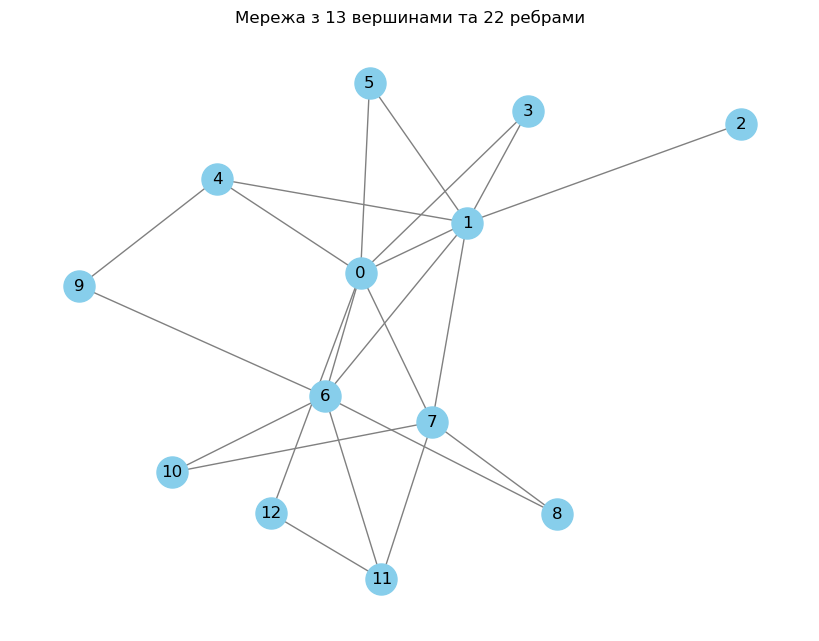

In [131]:
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(network)  # Розташування вершин графа
nx.draw(network, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
plt.title(f"Мережа з {len(network.nodes)} вершинами та {len(network.edges)} ребрами")
plt.show()

In [132]:
def analyze_network(N, m=2):
    """
    Аналізує розподіл ступенів мережі та обчислює показники скейлінгу
    
    Параметри:
        N (int): Кількість вершин
        m (int): Кількість ребер на нову вершину
    """
    # Будуємо мережу
    network = build_network(m, N)
    
    # Отримуємо послідовність ступенів
    degrees = dict(network.degree())
    degree_values = list(degrees.values())
    
    # Обчислюємо частотний розподіл
    degree_counts = Counter(degree_values)
    unique_degrees = np.array(list(degree_counts.keys()))
    frequencies = np.array(list(degree_counts.values())) / N  # Нормалізуємо частоти
    
    # Обчислюємо ранговий розподіл
    sorted_degrees = np.array(sorted(degree_values, reverse=True))
    ranks = np.arange(1, len(sorted_degrees) + 1)
    
    # Видаляємо нульові частоти та ступені для логарифмічних обчислень
    mask_freq = frequencies > 0
    unique_degrees = unique_degrees[mask_freq]
    frequencies = frequencies[mask_freq]
    
    # Обчислюємо показники скейлінгу
    # Частотний розподіл
    log_degrees_freq = np.log(unique_degrees)
    log_frequencies = np.log(frequencies)
    freq_slope, freq_intercept = np.polyfit(log_degrees_freq, log_frequencies, 1)
    
    # Ранговий розподіл
    log_ranks = np.log(ranks)
    log_sorted_degrees = np.log(sorted_degrees)
    rank_slope, rank_intercept = np.polyfit(log_ranks, log_sorted_degrees, 1)
    
    # Будуємо графіки розподілів
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Графік частотного розподілу
    ax1.scatter(unique_degrees, frequencies, alpha=0.6)
    ax1.plot(unique_degrees, np.exp(freq_intercept + freq_slope * log_degrees_freq), 
             'r-', label=f'γ = {-freq_slope:.2f}')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Ступінь (k)')
    ax1.set_ylabel('P(k)')
    ax1.set_title('Частотний розподіл')
    ax1.legend()
    ax1.grid(True)
    
    # Графік рангового розподілу
    ax2.scatter(ranks, sorted_degrees, alpha=0.6)
    ax2.plot(ranks, np.exp(rank_intercept + rank_slope * log_ranks), 
             'r-', label=f'α = {-rank_slope:.2f}')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Ранг (r)')
    ax2.set_ylabel('Ступінь (k)')
    ax2.set_title('Ранговий розподіл')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    
    return {
        'frequency_exponent': -freq_slope,
        'rank_exponent': -rank_slope,
        'network': network
    }

Ступені вершин на момент t = 8:
Вершина 0: ступінь = 6
Вершина 1: ступінь = 5
Вершина 2: ступінь = 4
Вершина 3: ступінь = 2
Вершина 4: ступінь = 3
Вершина 5: ступінь = 4
Вершина 6: ступінь = 4
Вершина 7: ступінь = 2
Вершина 8: ступінь = 2
Вершина 9: ступінь = 2
Вершина 10: ступінь = 2

Ймовірності приєднання нової вершини (9-ї) до кожної з існуючих вершин:
Ймовірність приєднання до вершини 0: 0.3333
Ймовірність приєднання до вершини 1: 0.2778
Ймовірність приєднання до вершини 2: 0.2222
Ймовірність приєднання до вершини 3: 0.1111
Ймовірність приєднання до вершини 4: 0.1667
Ймовірність приєднання до вершини 5: 0.2222
Ймовірність приєднання до вершини 6: 0.2222
Ймовірність приєднання до вершини 7: 0.1111
Ймовірність приєднання до вершини 8: 0.1111
Ймовірність приєднання до вершини 9: 0.1111
Ймовірність приєднання до вершини 10: 0.1111
Показник скейлінгу частотного розподілу (γ): 0.77
Показник скейлінгу рангового розподілу (α): 0.34

Чи є мережа безмасштабною? False
Мережа не має типових в

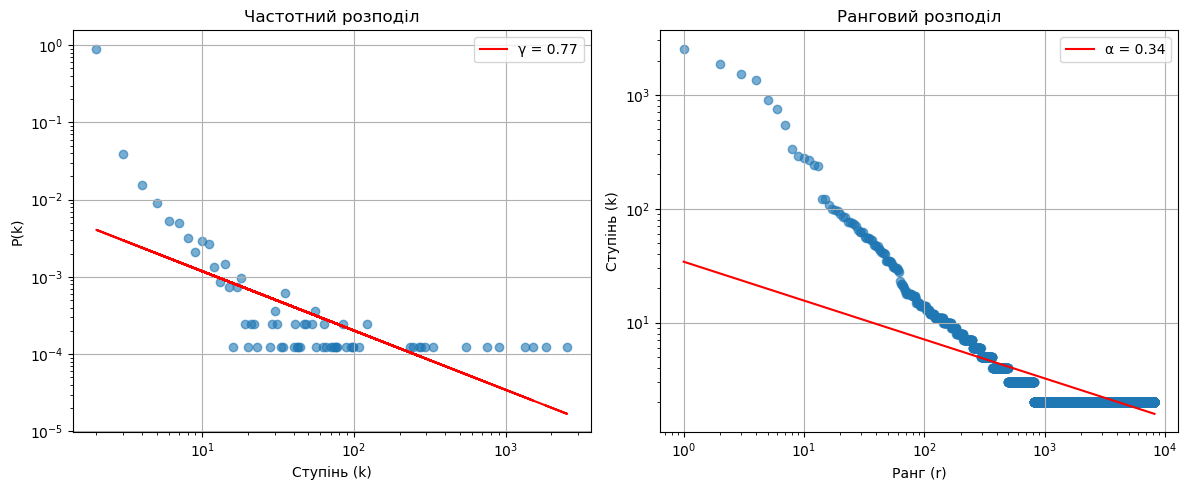

In [133]:
# Запускаємо аналіз
N = 8192
results = analyze_network(N-3)

print(f"Показник скейлінгу частотного розподілу (γ): {results['frequency_exponent']:.2f}")
print(f"Показник скейлінгу рангового розподілу (α): {results['rank_exponent']:.2f}")

# Перевіряємо чи є мережа безмасштабною
is_scale_free = 2 < results['frequency_exponent'] < 3
print(f"\nЧи є мережа безмасштабною? {is_scale_free}")
if is_scale_free:
    print("Мережа має властивості безмасштабності, оскільки показник частотного розподілу знаходиться між 2 та 3.")
else:
    print("Мережа не має типових властивостей безмасштабності.")

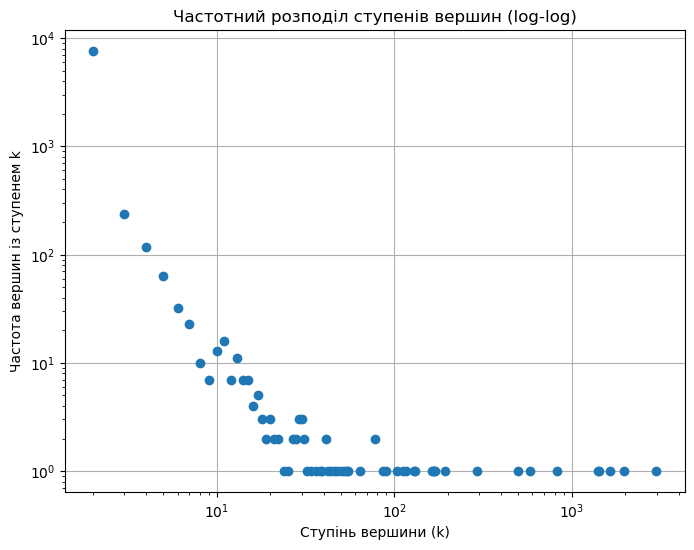

In [136]:
# Графік частотного розподілу у подвійному логарифмічному масштабі
plt.figure(figsize=(8, 6))
plt.loglog(degrees, frequencies, marker='o', linestyle='none')
plt.xlabel("Ступінь вершини (k)")
plt.ylabel("Частота вершин із ступенем k")
plt.title("Частотний розподіл ступенів вершин (log-log)")
plt.grid(True)
plt.show()

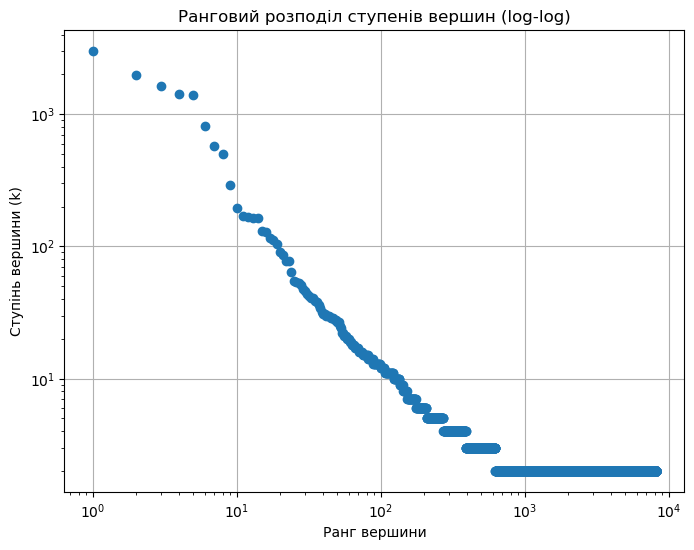

In [135]:
# Графік рангового розподілу
sorted_degrees = sorted(degree_values, reverse=True)
ranks = np.arange(1, len(sorted_degrees) + 1)

plt.figure(figsize=(8, 6))
plt.loglog(ranks, sorted_degrees, marker='o', linestyle='none')
plt.xlabel("Ранг вершини")
plt.ylabel("Ступінь вершини (k)")
plt.title("Ранговий розподіл ступенів вершин (log-log)")
plt.grid(True)
plt.show()

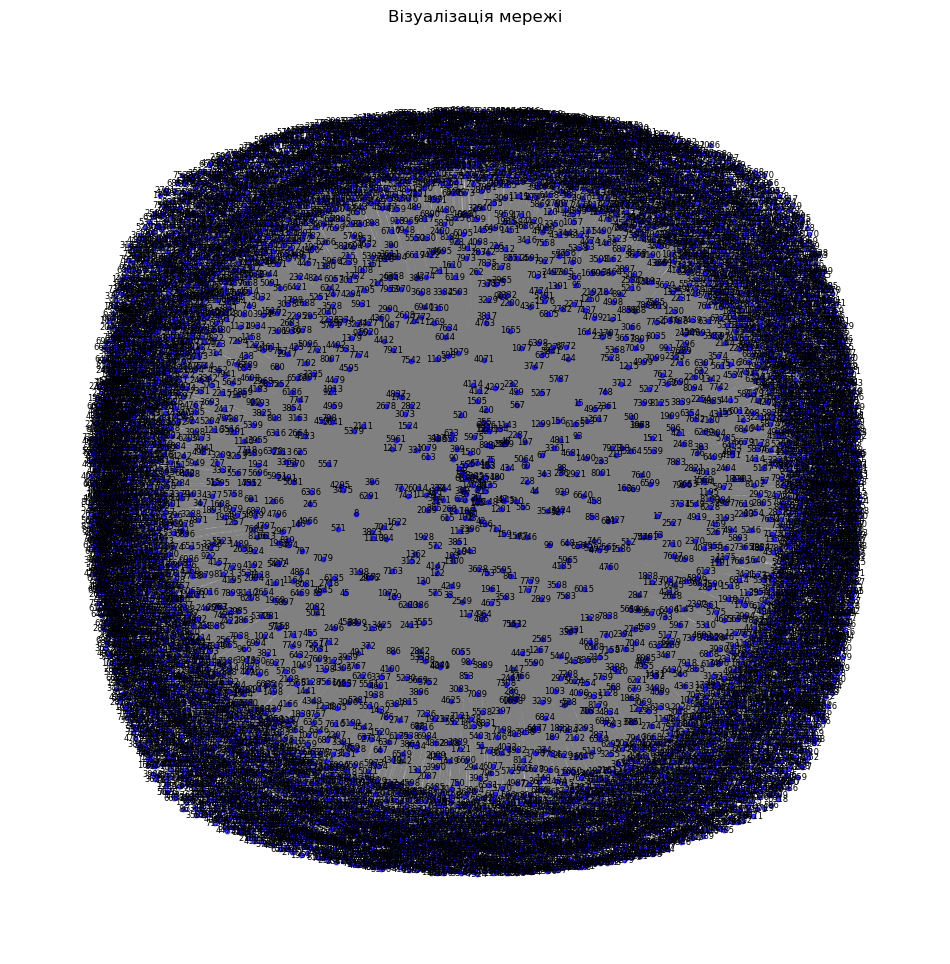

In [86]:
import matplotlib.pyplot as plt
import networkx as nx

# Функція для візуалізації мережі
def visualize_network(G, node_size=10, font_size=8, layout='spring'):
    # Вибір методу розташування вершин
    if layout == 'spring':
        pos = nx.spring_layout(G, k=0.15, iterations=20)  # spring layout для великої мережі
    elif layout == 'circular':
        pos = nx.circular_layout(G)  # кругове розташування
    elif layout == 'random':
        pos = nx.random_layout(G)  # випадкове розташування
    else:
        pos = nx.spring_layout(G)  # стандартний spring layout

    plt.figure(figsize=(12, 12))
    
    # Візуалізація графа
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='blue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.6, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=font_size, font_color='black')

    plt.title("Візуалізація мережі")
    plt.axis('off')  # вимкнення осей
    plt.show()

# Візуалізація мережі з 8192 вершинами
visualize_network(network_large, node_size=10, font_size=6, layout='spring')
